In [1]:
import dask_awkward as dak
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
from distributed import LocalCluster, Client, progress
import dask.dataframe as dd
import pandas as pd


client =  Client(n_workers=31,  threads_per_worker=1, processes=True, memory_limit='4 GiB') 

In [2]:


full_load_path = f"/depot/cms/users/yun79/results/stage1/test_VBF-filter_JECoff_05June2024/2018/f1_0/dy_VBF_filter/*/*.parquet"
df_dyVBFfilter_UL = dak.from_parquet(full_load_path)
full_load_path = f"/depot/cms/users/yun79/results/stage1/test_VBF-filter_JECoff_05June2024/2018/f1_0/dy_m105_160_vbf_amc/*/*.parquet"
df_dyVBFfilter_Rereco = dak.from_parquet(full_load_path)

variables = ["dimuon_mass",
             "mu1_pt","mu1_eta",
             "mu2_pt","mu2_eta",
             "jet1_pt", "jet1_eta", 
             "jet2_pt", "jet2_eta", 
             "gjet1_pt", "gjet1_eta", 
             "gjet2_pt", "gjet2_eta", 
             "gjet1_mass",
             "gjet2_mass",
            ]
fields2load = variables + [ "fraction", "h_sidebands", "h_peak", "z_peak", "vbf_cut","nBtagLoose", "nBtagMedium","gjj_mass", "jj_mass"]
# fields2load.append("weights")
# add in wegiht portions
for field in df_dyVBFfilter_UL.fields:
    if "wgt_nominal" in field:
        fields2load.append(field)
# load in the features once to save runtime
df_dyVBFfilter_UL = df_dyVBFfilter_UL[fields2load].compute()
df_dyVBFfilter_Rereco = df_dyVBFfilter_Rereco[fields2load].compute()

In [3]:
from coffea.analysis_tools import Weights
wgt_l = []
for field in df_dyVBFfilter_UL.fields:
    if "wgt_nominal" in field:
        wgt_l.append(field)
# remove wgt_nominal_total, which is just all weights multiplied
wgt_l.remove("wgt_nominal_total")
weights_UL_collection = Weights(len(df_dyVBFfilter_UL.wgt_nominal_total), storeIndividual=True)
weights_Rereco_collection = Weights(len(df_dyVBFfilter_Rereco.wgt_nominal_total), storeIndividual=True)
# add in different weights one by one
for wgt_name in wgt_l:
    weights_UL_collection.add(wgt_name, df_dyVBFfilter_UL[wgt_name])
    weights_Rereco_collection.add(wgt_name, df_dyVBFfilter_Rereco[wgt_name])

In [4]:
weights_Rereco_collection.weightStatistics

{'wgt_nominal_genWeight': WeightStatistics(sumw=1294963274.3582, sumw2=489714860565.7775, minw=-204.2561798095703, maxw=204.2561798095703, n=11748486),
 'wgt_nominal_genWeight_normalization': WeightStatistics(sumw=0.0037337640368470958, sumw2=1.1866204618069732e-12, minw=3.178081019841323e-10, maxw=3.178081019841323e-10, n=11748486),
 'wgt_nominal_xsec': WeightStatistics(sumw=23614456.86000067, sumw2=47465058.28860118, minw=2.01, maxw=2.01, n=11748486),
 'wgt_nominal_lumi': WeightStatistics(sumw=704556705420.0, sumw2=4.22522656240374e+16, minw=59970.0, maxw=59970.0, n=11748486),
 'wgt_nominal_pu': WeightStatistics(sumw=12054356.615959974, sumw2=12433761.422998415, minw=0.4090519016783799, maxw=1.339562335517277, n=11748486),
 'wgt_nominal_muID': WeightStatistics(sumw=11148225.027485186, sumw2=10578632.962871723, minw=0.9489073764470426, maxw=0.9489073764470426, n=11748486),
 'wgt_nominal_muIso': WeightStatistics(sumw=12349377.310674872, sumw2=12981001.974331517, minw=1.0511462762669908

In [5]:
print(weights_UL_collection.partial_weight(include=["wgt_nominal_genWeight_normalization"] ) )
print(weights_Rereco_collection.partial_weight(include=["wgt_nominal_genWeight_normalization"] ) )
print(weights_UL_collection.partial_weight(include=["wgt_nominal_genWeight"] ) )
print(weights_Rereco_collection.partial_weight(include=["wgt_nominal_genWeight"] ) )
print(len(weights_UL_collection.partial_weight(include=["wgt_nominal_genWeight"] ) ))
print(len(weights_Rereco_collection.partial_weight(include=["wgt_nominal_genWeight"] ) ))

[4.51797368e-10 4.51797368e-10 4.51797368e-10 ... 4.51797368e-10
 4.51797368e-10 4.51797368e-10]
[3.17808102e-10 3.17808102e-10 3.17808102e-10 ... 3.17808102e-10
 3.17808102e-10 3.17808102e-10]
[ 204.25617981 -204.25617981  204.25617981 ...  204.25617981  204.25617981
  204.25617981]
[ 204.25617981  204.25617981  204.25617981 ...  204.25617981 -204.25617981
  204.25617981]
8269387
11748486


In [6]:
8269387*4.51797368e-10

0.003736087281573416

In [7]:
11748486*3.17808102e-10

0.003733764037033572

In [ ]:
wgt_UL = weights_UL_collection.partial_weight(include=["wgt_nominal_genWeight", "wgt_nominal_genWeight_normalization"])
wgt_Rereco = weights_Rereco_collection.partial_weight(include=["wgt_nominal_genWeight", "wgt_nominal_genWeight_normalization"])
print(np.sum(wgt_UL))
print(np.sum(wgt_Rereco))
print((wgt_UL))
print((wgt_Rereco))
print(len(wgt_UL))
print(len(wgt_Rereco))

In [54]:
wgt_UL = weights_UL_collection.partial_weight(include=["wgt_nominal_xsec", "wgt_nominal_lumi"])
wgt_Rereco = weights_Rereco_collection.partial_weight(include=["wgt_nominal_xsec", "wgt_nominal_lumi"])
print(np.sum(wgt_UL))
print(np.sum(wgt_Rereco))
print((wgt_UL))
print((wgt_Rereco))
print(len(wgt_UL))
print(len(wgt_Rereco))


996789428163.9166
1416158977894.188
[120539.7 120539.7 120539.7 ... 120539.7 120539.7 120539.7]
[120539.7 120539.7 120539.7 ... 120539.7 120539.7 120539.7]
8269387
11748486


In [55]:
wgt_UL = weights_UL_collection.partial_weight(exclude=["wgt_nominal_genWeight", "wgt_nominal_genWeight_normalization"])
wgt_Rereco = weights_Rereco_collection.partial_weight(exclude=["wgt_nominal_genWeight", "wgt_nominal_genWeight_normalization"])
print(np.sum(wgt_UL))
print(np.sum(wgt_Rereco))
print((wgt_UL))
print((wgt_Rereco))
print(len(wgt_UL))
print(len(wgt_Rereco))




1037766154844.8983
1580579125000.23
[182170.02155479 142093.04693469 110321.25286491 ... 158056.64678831
 122490.15503608  96367.26746493]
[109369.06134154 116520.22222325 113094.81160313 ... 113542.39065877
 121925.69782722 103572.35377029]
8269387
11748486


In [12]:
0.003736087281573416/0.003733764037033572

1.0006222258602313

In [17]:
9.22824044e-08/6.49142688e-08

1.4216043114391514

In [18]:
1/1.4216043114391514


0.7034306184592651

In [24]:
print(ak.sum(ak.is_none(df_dyVBFfilter_UL.gjj_mass)))
print(ak.sum(ak.is_none(df_dyVBFfilter_Rereco.gjj_mass)))

46008
3517664


In [25]:
11748486/8269387

1.4207203024843316

In [26]:
3517664/46008

76.45765953747174

In [27]:
wgt_UL = weights_UL_collection.partial_weight(include=["wgt_nominal_genWeight"])
wgt_Rereco = weights_Rereco_collection.partial_weight(include=["wgt_nominal_genWeight"])
print(np.sum(wgt_UL))
print(np.sum(wgt_Rereco))
print((wgt_UL))
print((wgt_Rereco))
print(len(wgt_UL))
print(len(wgt_Rereco))

911672175.9126022
1294963274.3582
[ 204.25617981 -204.25617981  204.25617981 ...  204.25617981  204.25617981
  204.25617981]
[ 204.25617981  204.25617981  204.25617981 ...  204.25617981 -204.25617981
  204.25617981]
8269387
11748486


In [28]:
1/3.17808102e-10

3146552884.2936797

In [29]:
1/4.51797368e-10

2213381641.4795933

hist_VbfFilter_UL: [0.000672, 0.000518, 0.000714, 0.0899, ..., 0.0042, 0.00351, 0.00294, 0.00252]
hist_VbfFilter_Rereco: [7.13e-06, 5.64e-06, 1.91e-05, 0.053, ..., 0.00246, 0.00204, 0.00172, 0.00148]


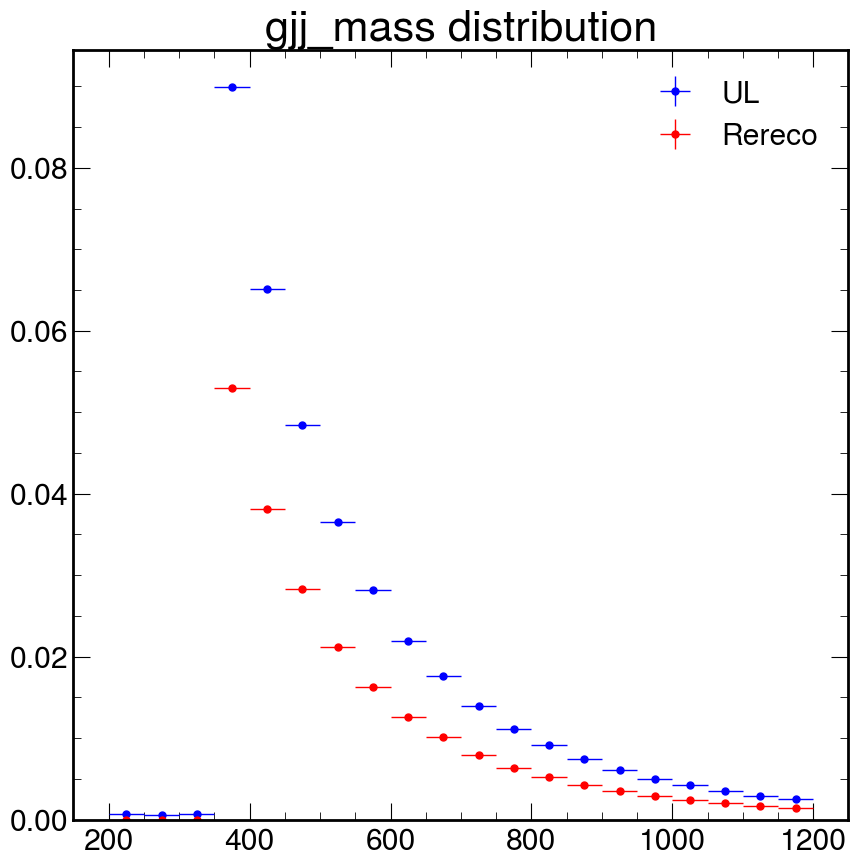

<Figure size 1000x1000 with 0 Axes>

In [73]:
"""
dijet mass plot of vbf filtered DY vs normal DY 
"""
import sys
np.set_printoptions(threshold=sys.maxsize)

import mplhep as hep
plt.style.use(hep.style.CMS)
binning_map = {
    "gjj_mass" : [200, 1200, 21],
    # "jj_mass" : [250, 2_000, 21],
    "jj_mass" : [200, 500, 21],
}

wgt_UL = weights_UL_collection.partial_weight(include=["wgt_nominal_genWeight", "wgt_nominal_genWeight_normalization"])
wgt_Rereco = weights_Rereco_collection.partial_weight(include=["wgt_nominal_genWeight", "wgt_nominal_genWeight_normalization"])
for var in ["gjj_mass"]:
    fig, ax_main = plt.subplots()
    binning = np.linspace(*binning_map[var])
    hist_VbfFilter_UL, edges = np.histogram(df_dyVBFfilter_UL[var], bins=binning, weights=wgt_UL)
    print(f"hist_VbfFilter_UL: {hist_VbfFilter_UL}")
    hist_VbfFilter_UL_w2, _ = np.histogram(ak.fill_none(df_dyVBFfilter_UL[var], value=0.0), bins=binning, weights=wgt_UL*wgt_UL)
    hist_VbfFilter_Rereco, _= np.histogram(ak.fill_none(df_dyVBFfilter_Rereco[var], value=0.0), bins=binning, weights=wgt_Rereco)
    print(f"hist_VbfFilter_Rereco: {hist_VbfFilter_Rereco}")
    hist_VbfFilter_Rereco_w2, _= np.histogram(df_dyVBFfilter_Rereco[var], bins=binning, weights=wgt_Rereco*wgt_Rereco)


    err_VbfFilter_UL = np.sqrt(hist_VbfFilter_UL_w2)
    # print(f"err_VbfFilter_UL: {err_VbfFilter_UL}")
    hep.histplot(hist_VbfFilter_UL, bins=binning, 
         histtype='errorbar', 
        label="UL", 
         xerr=True, 
         yerr=err_VbfFilter_UL,
        color = "blue",
        ax=ax_main
    )
    err_VbfFilter_Rereco = np.sqrt(hist_VbfFilter_Rereco_w2)
    # print(f"err_VbfFilter_Rereco: {err_VbfFilter_Rereco}")
    hep.histplot(hist_VbfFilter_Rereco, bins=binning, 
         histtype='errorbar', 
        label="Rereco", 
         xerr=True, 
         yerr=err_VbfFilter_Rereco,
        color = "red",
        ax=ax_main
    )
    plt.legend(loc="upper right")
    plt.title(f"{var} distribution")
    # plt.savefig(f"./quick_plots/{var}_separate_normal.pdf")
    plt.show()
    plt.clf()

err_VbfFilter_UL: [0, 0, 0, 0.000124, 0.000106, ..., 2.74e-05, 2.51e-05, 2.31e-05, 2.12e-05]
err_VbfFilter_Rereco: [0, 0, 0, 8.88e-05, 7.57e-05, ..., 1.98e-05, 1.81e-05, 1.67e-05, 1.54e-05]


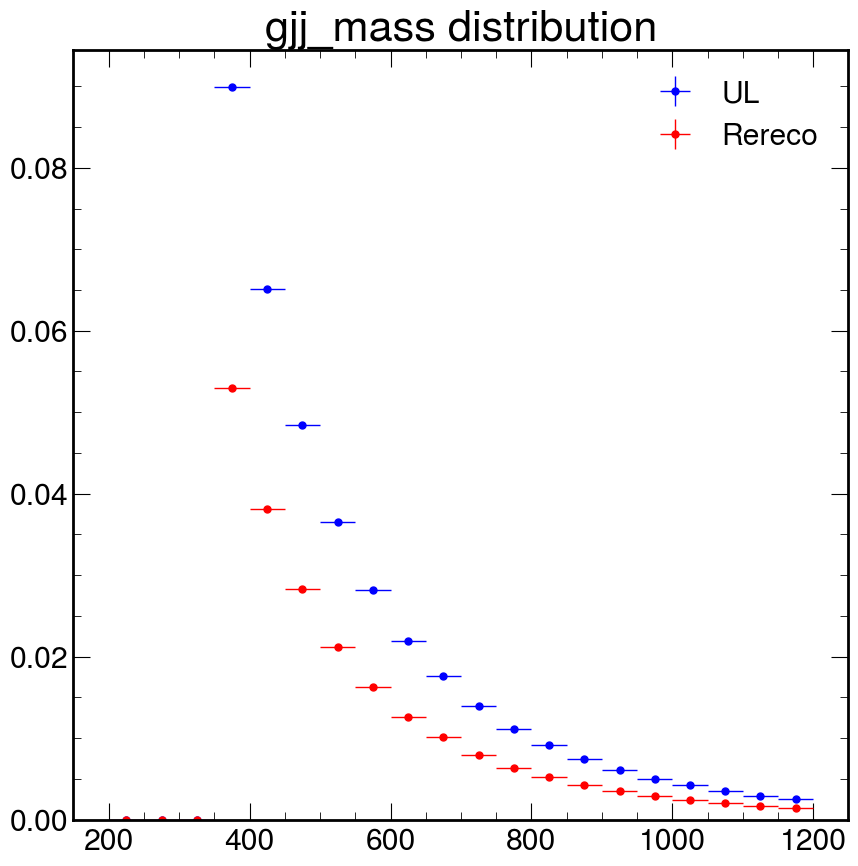

<Figure size 1000x1000 with 0 Axes>

In [56]:
vbf_filter_UL = ak.fill_none((df_dyVBFfilter_UL.gjj_mass > 350), value=False)
vbf_filter_Rereco = ak.fill_none((df_dyVBFfilter_Rereco.gjj_mass > 350), value=False)

"""
dijet mass plot of vbf filtered DY vs normal DY 
"""
import mplhep as hep
plt.style.use(hep.style.CMS)
binning_map = {
    "gjj_mass" : [200, 1200, 21],
    # "jj_mass" : [250, 2_000, 21],
    "jj_mass" : [200, 500, 21],
}

wgt_UL = weights_UL_collection.partial_weight(include=["wgt_nominal_genWeight", "wgt_nominal_genWeight_normalization"])*vbf_filter_UL
wgt_Rereco = weights_Rereco_collection.partial_weight(include=["wgt_nominal_genWeight", "wgt_nominal_genWeight_normalization"])*vbf_filter_Rereco

for var in ["gjj_mass"]:
    fig, ax_main = plt.subplots()
    binning = np.linspace(*binning_map[var])
    hist_VbfFilter_UL, edges = np.histogram(df_dyVBFfilter_UL[var], bins=binning, weights=wgt_UL)
    hist_VbfFilter_UL_w2, _ = np.histogram(df_dyVBFfilter_UL[var], bins=binning, weights=wgt_UL*wgt_UL)
    hist_VbfFilter_Rereco, _= np.histogram(df_dyVBFfilter_Rereco[var], bins=binning, weights=wgt_Rereco)
    hist_VbfFilter_Rereco_w2, _= np.histogram(df_dyVBFfilter_Rereco[var], bins=binning, weights=wgt_Rereco*wgt_Rereco)


    err_VbfFilter_UL = np.sqrt(hist_VbfFilter_UL_w2)
    print(f"err_VbfFilter_UL: {err_VbfFilter_UL}")
    hep.histplot(hist_VbfFilter_UL, bins=binning, 
         histtype='errorbar', 
        label="UL", 
         xerr=True, 
         yerr=err_VbfFilter_UL,
        color = "blue",
        ax=ax_main
    )
    err_VbfFilter_Rereco = np.sqrt(hist_VbfFilter_Rereco_w2)
    print(f"err_VbfFilter_Rereco: {err_VbfFilter_Rereco}")
    hep.histplot(hist_VbfFilter_Rereco, bins=binning, 
         histtype='errorbar', 
        label="Rereco", 
         xerr=True, 
         yerr=err_VbfFilter_Rereco,
        color = "red",
        ax=ax_main
    )
    plt.legend(loc="upper right")
    plt.title(f"{var} distribution")
    # plt.savefig(f"./quick_plots/{var}_separate_normal.pdf")
    plt.show()
    plt.clf()

err_VbfFilter_UL: [0, 0, 0, 0.000106, 9.01e-05, ..., 2.34e-05, 2.15e-05, 1.98e-05, 1.82e-05]
err_VbfFilter_Rereco: [0, 0, 0, 8.88e-05, 7.57e-05, ..., 1.98e-05, 1.81e-05, 1.67e-05, 1.54e-05]


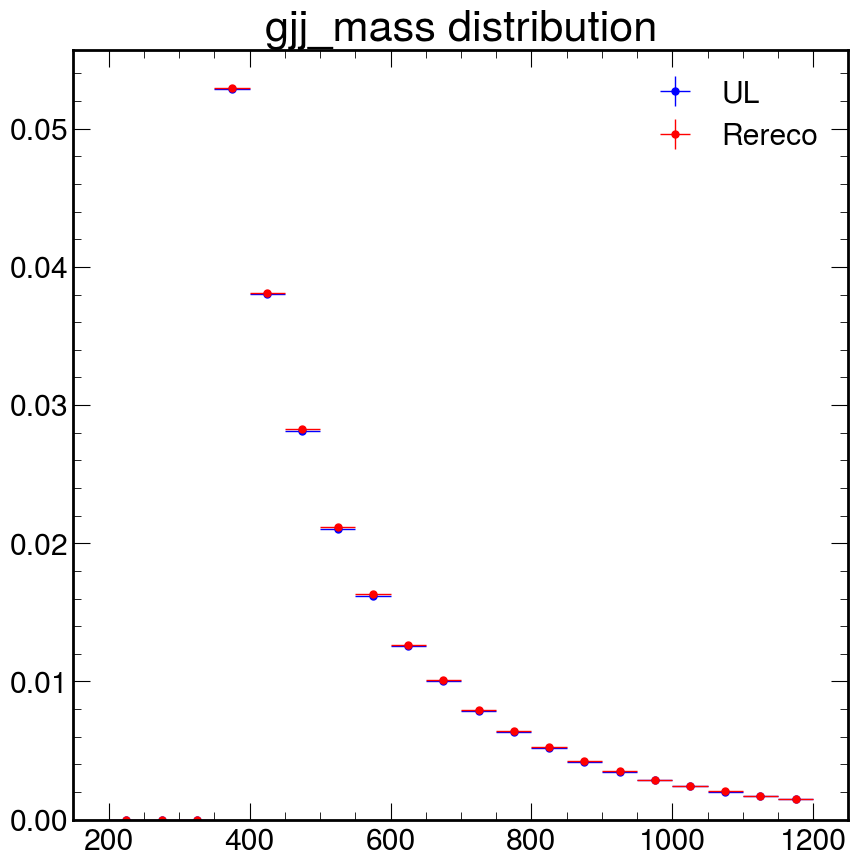

<Figure size 1000x1000 with 0 Axes>

In [14]:
vbf_filter_UL = ak.fill_none((df_dyVBFfilter_UL.gjj_mass > 350), value=False)
vbf_filter_Rereco = ak.fill_none((df_dyVBFfilter_Rereco.gjj_mass > 350), value=False)

"""
dijet mass plot of vbf filtered DY vs normal DY 
"""
import mplhep as hep
plt.style.use(hep.style.CMS)
binning_map = {
    "gjj_mass" : [200, 1200, 21],
    # "jj_mass" : [250, 2_000, 21],
    "jj_mass" : [200, 500, 21],
}

wgt_UL = weights_UL_collection.partial_weight(include=["wgt_nominal_genWeight", "wgt_nominal_genWeight_normalization"])*vbf_filter_UL
wgt_Rereco = weights_Rereco_collection.partial_weight(include=["wgt_nominal_genWeight", "wgt_nominal_genWeight_normalization"])*vbf_filter_Rereco
# filter out events with genjet1 and 2 less than 10 GeV
UL_extraFilter = (df_dyVBFfilter_UL["gjet1_pt"] < 10) | (df_dyVBFfilter_UL["gjet2_pt"] < 10) 
UL_extraFilter = ~UL_extraFilter
wgt_UL = wgt_UL*UL_extraFilter
for var in ["gjj_mass"]:
    fig, ax_main = plt.subplots()
    binning = np.linspace(*binning_map[var])
    hist_VbfFilter_UL, edges = np.histogram(df_dyVBFfilter_UL[var], bins=binning, weights=wgt_UL)
    hist_VbfFilter_UL_w2, _ = np.histogram(df_dyVBFfilter_UL[var], bins=binning, weights=wgt_UL*wgt_UL)
    hist_VbfFilter_Rereco, _= np.histogram(df_dyVBFfilter_Rereco[var], bins=binning, weights=wgt_Rereco)
    hist_VbfFilter_Rereco_w2, _= np.histogram(df_dyVBFfilter_Rereco[var], bins=binning, weights=wgt_Rereco*wgt_Rereco)


    err_VbfFilter_UL = np.sqrt(hist_VbfFilter_UL_w2)
    print(f"err_VbfFilter_UL: {err_VbfFilter_UL}")
    hep.histplot(hist_VbfFilter_UL, bins=binning, 
         histtype='errorbar', 
        label="UL", 
         xerr=True, 
         yerr=err_VbfFilter_UL,
        color = "blue",
        ax=ax_main
    )
    err_VbfFilter_Rereco = np.sqrt(hist_VbfFilter_Rereco_w2)
    print(f"err_VbfFilter_Rereco: {err_VbfFilter_Rereco}")
    hep.histplot(hist_VbfFilter_Rereco, bins=binning, 
         histtype='errorbar', 
        label="Rereco", 
         xerr=True, 
         yerr=err_VbfFilter_Rereco,
        color = "red",
        ax=ax_main
    )
    plt.legend(loc="upper right")
    plt.title(f"{var} distribution")
    # plt.savefig(f"./quick_plots/{var}_separate_normal.pdf")
    plt.show()
    plt.clf()

In [57]:

print(hist_VbfFilter_UL[10:]/hist_VbfFilter_Rereco[10:])
print(np.mean(hist_VbfFilter_UL[10:]/hist_VbfFilter_Rereco[10:]))

[1.75, 1.75, 1.73, 1.73, 1.73, 1.74, 1.71, 1.71, 1.71, 1.7]
1.7267555368171075


In [50]:
np.linspace(*[200, 1200, 21])

array([ 200.,  250.,  300.,  350.,  400.,  450.,  500.,  550.,  600.,
        650.,  700.,  750.,  800.,  850.,  900.,  950., 1000., 1050.,
       1100., 1150., 1200.])

In [72]:
vbf_filter_UL = ak.fill_none((df_dyVBFfilter_UL.gjj_mass > 350), value=False)
vbf_filter_Rereco = ak.fill_none((df_dyVBFfilter_Rereco.gjj_mass > 350), value=False)
filterEff_UL  = ak.sum(vbf_filter_UL) / len(vbf_filter_UL)
print(filterEff_UL)
filterEff_Rereco  = ak.sum(vbf_filter_Rereco) / len(vbf_filter_Rereco)
print(filterEff_Rereco)

0.9622259787817404
0.700364370353763


In [12]:
nonfilter = ak.is_none(df_dyVBFfilter_UL.gjj_mass )
print(df_dyVBFfilter_UL.gjet1_pt[nonfilter])
print(df_dyVBFfilter_UL.gjet2_pt[nonfilter])
nonfilter = ak.is_none(df_dyVBFfilter_Rereco.gjj_mass )
print(df_dyVBFfilter_Rereco.gjet1_pt[nonfilter])
print(df_dyVBFfilter_Rereco.gjet2_pt[nonfilter])

[3.36, 5.62, 83.6, 8.51, 3.31, 3.69, ..., 7.75, 78.5, 4.76, 35.2, 44.8, 4.25]
[None, None, None, None, None, None, ..., None, None, None, None, None, None]
[None, None, None, None, 14, None, ..., None, 65.5, 16.4, 19.8, None, None]
[None, None, None, None, None, None, ..., None, None, None, None, None, None]


In [8]:
vbf_filter_UL = ak.fill_none((df_dyVBFfilter_UL.gjj_mass > 350), value=False)
print(df_dyVBFfilter_UL.gjet1_pt[vbf_filter_UL])
print(df_dyVBFfilter_UL.gjet2_pt[vbf_filter_UL])
print(df_dyVBFfilter_UL.gjet1_eta[vbf_filter_UL])
print(df_dyVBFfilter_UL.gjet2_eta[vbf_filter_UL])
print(df_dyVBFfilter_UL.gjet1_mass[vbf_filter_UL])
print(df_dyVBFfilter_UL.gjet2_mass[vbf_filter_UL])
print(df_dyVBFfilter_UL.gjj_mass[vbf_filter_UL])

[7.57, 86.7, 22.3, 19, 23.8, 9.01, 72, ..., 12.8, 6.82, 116, 13.8, 45.3, 7.38]
[6.77, 26.9, 14.4, 8.45, 7.96, 7.82, ..., 11.9, 6.19, 23.7, 7.1, 40.8, 7.22]
[-2.83, 1.81, 4.81, 3.6, 3.08, 2.93, ..., -4.56, 3.26, -1.74, 4.57, -1.79, 4.15]
[5.34, -2.9, -2.67, -3.67, -3.7, -4.65, ..., -5.31, 4.47, -2.94, 2.98, -4.6]
[1.02, 3.31, 8.09, 6.79, 3.36, 6.2, ..., 2.38, 1.64, 24.8, 6.89, 3.91, 2.9]
[1.55, 7.07, 3.03, 2.39, 1.52, 2.59, ..., 3.88, 2.93, 4.97, 2.02, 4.15, 2.96]
[426, 514, 754, 477, 407, 371, 491, ..., 483, 612, 471, 1.17e+03, 422, 471, 580]


In [ ]:

px_ = obj_pt * np.cos(obj.phi)
py_ = obj_pt * np.sin(obj.phi)
pz_ = obj_pt * np.sinh(obj.eta)
e_ = np.sqrt(px_**2 + py_**2 + pz_**2 + obj.mass**2)

In [76]:
vbf_filter_UL = ak.is_none(df_dyVBFfilter_UL.gjj_mass )
vbf_filter_Rereco = ak.is_none(df_dyVBFfilter_Rereco.gjj_mass)
filterEff_UL  = ak.sum(vbf_filter_UL) / len(vbf_filter_UL)
print(filterEff_UL)
filterEff_Rereco  = ak.sum(vbf_filter_Rereco) / len(vbf_filter_Rereco)
print(filterEff_Rereco)

0.0055636530253088895
0.29941423941774287


In [59]:
len(vbf_filter_UL)

8269387

In [62]:
0.700364370353763/0.9622259787817404

0.7278585132782255

In [67]:
hist_VbfFilter_Rereco[7]

0.01629593461648035

In [68]:
hist_VbfFilter_UL[7]

0.02823930558790702

In [17]:
"""
check the number of events for non extension rereco events
"""
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
import glob
load_path = "/eos/purdue/store/mc/RunIIAutumn18NanoAODv6/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/NANOAODSIM/Nano25Oct2019_VBFPostMGFilter_102X_upgrade2018_realistic_v20-v1"
fnames = glob.glob(f"{load_path}/*/*.root")
file_input = {fname : {"object_path": "Runs"} for fname in fnames}
runs = NanoEventsFactory.from_root(
        file_input,
        metadata={},
        schemaclass=BaseSchema,
        uproot_options={"timeout":2400},
).events()  
ak.sum(runs.genEventCount_).compute()

9776913

In [18]:
load_path = "/eos/purdue/store/mc/RunIIAutumn18NanoAODv6/DYJetsToLL_M-105To160_VBFFilter_TuneCP5_PSweights_13TeV-amcatnloFXFX-pythia8/NANOAODSIM/Nano25Oct2019_VBFPostMGFilter_102X_upgrade2018_realistic_v20_ext1-v1"
fnames = glob.glob(f"{load_path}/*/*.root")
file_input = {fname : {"object_path": "Runs"} for fname in fnames}
runs = NanoEventsFactory.from_root(
        file_input,
        metadata={},
        schemaclass=BaseSchema,
        uproot_options={"timeout":2400},
).events()  
ak.sum(runs.genEventCount_).compute()

19729948

In [19]:
19729948 + 9776913

29506861

In [20]:
20756969

20756969